# Kaggle Titanic 분류
로지스틱 회귀, 결정 트리, 랜덤 포레스트를 이용한 분류
[참고 | Titanic (Classifiaction Models)](https://www.kaggle.com/code/fatmakursun/titanic-classification-models)
## 데이터셋 전처리 및 EDA
캐글의 경우, 훈련용과 테스트용 데이터 셋이 따로 제공됨
### 사용 라이브러리

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### Data Load

In [3]:
train = pd.read_csv("data/train.csv", encoding="utf-8")
test = pd.read_csv("data/test.csv", encoding="utf-8")
print(f"train: {train.shape}\ntest: {test.shape}")

train: (891, 12)
test: (418, 11)


### EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Survived: 생존 여부 => 0 = No, 1 = Yes
- pclass: 티켓 등급 => 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex: 성별
- Age: 나이
- Sibsp: 함께 탑승한 형제자매, 배우자의 수
- Parch: 함께 탑승한 부모, 자식의 수
- Ticket: 티켓 번호
- Fare: 운임
- Cabin: 객실 번호
- Embarked: 탑승 항구 => C = Cherbourg, Q = Queenstown, S = Southampton

#### 결측치 확인

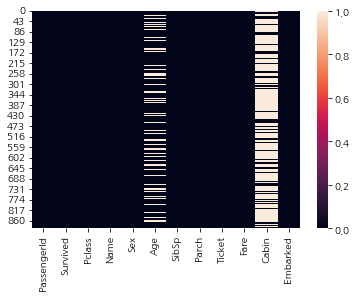

In [6]:
_ = sns.heatmap(train.isnull())

In [7]:
temp = train.isnull().mean()
temp[temp!=0]

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

`Age`에서 20%, `Cabin`에서 77%, `Embarked`에서 0.002% 정도의 결측치가 존재함  
`Cabin`과 `Embarked`는 문자열 형식의 데이터로, 모델과 직접적인 영향을 미비할 것이라고 생각됨

#### Data Cleaning
##### Age

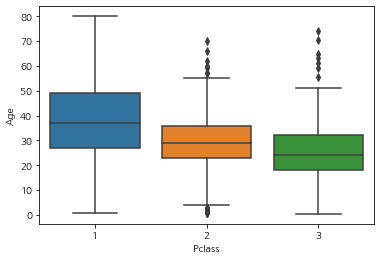

In [8]:
_ = sns.boxplot(data=train, x="Pclass", y="Age")

In [9]:
train.groupby("Pclass")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


결측치가 있는 `Age`를 `Pclass`의 평균 나이값을 이용해 대채하는 방식이 굉장히 인상 깊었음  
일반적으로 평균이나 중앙값을 이용하는 방식이 아닌, 다른 변수를 이용해 좀 더 균등하게 결측치를 대체할 수 있는 방식이라고 생각됨

In [10]:
def age_pclass(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass==1: return 38
        elif Pclass==2: return 29
        else: return 25
    else: return Age
    
train["Age"] = train[["Age", "Pclass"]].apply(age_pclass, axis=1)

##### Embarked
탑승지의 경우, 결측치의 양이 적고 크게 생존 여부와 큰 상관이 없을것 같으므로 임의로 채워줌

In [11]:
train["Embarked"] = train["Embarked"].fillna('S')

#### Cabin
`Cabin`의 경우 열을 버려줌

In [12]:
train.drop(columns='Cabin', axis=1, inplace=True)

In [13]:
train.dropna(inplace=True)

#### 범주형 데이터 변환
범주형 데이터는 학습에서 바로 사용이 불가능하기 때문에 수치형으로 변환이 필요합니다.  
예를 들어, `Sex`의 경우 `Male=0`, `Female=1`과 같이 변환을 합니다.

현재 범주형 데이터는, `Name, Sex, Ticket, Embarked`가 있음

#### pd.get_dummies
학습 이전에 모든 데이터를 수치로 변환해주는 전처리 작업이 필요함  
1. 수치형 데이터로 변환
2. 수치화된 데이터를 가변수화

##### Note!!! - 가변수화
수치형 데이터로만 변환하면, **서로 간의 관계성**이 생기게 되어버림
- 월, 화, 수 ... -> 1, 2, 3 ...
- 1+2=3 / 월+화=수라는 관계성이 성립해버림

`pandas`의 `get_dummies` 함수는 원핫인코딩을 이용하는 방식  
`get_dummies(data=, prefix=, prefix_sep=, dummy_na=, columns=, drop_first=, dtype=)` 형식으로 존재함
- data: one-hot encoding을 적용할 데이터
- prefix: 생성할 더미 데이터(가변수화된 데이터)의 컬럼 prefix
- prefix_sep: `default='_'`
- dummpy_na: `NaN`도 포함시킬지, `default=False`
- columns: 대상 컬럼
- drop_first: k개의 범주를 k-1개로 가변수화할 경우 사용
- dtype: 새로운 columns의 데이터 타입

In [14]:
sex = pd.get_dummies(data=train["Sex"], drop_first=True)
embark = pd.get_dummies(data=train["Embarked"], drop_first=True)

In [15]:
# 가변수화된 컬럼으로 대체
train.drop(columns=["Sex", "Embarked", "Name", "Ticket"], axis=1, inplace=True)
train = pd.concat([train, sex, embark], axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


## 학습 및 평가 준비하기

In [16]:
target = "Survived"
features_names = train.columns.tolist()
features_names.remove(target)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train[features_names], train[target], test_size=0.1, stratify=train[target])
print(f"X_trian: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_trian: (801, 9)
y_train: (801,)
X_test: (90, 9)
y_test: (90,)


## Classification - 분류
### Logistic Regression
시그모이드 함수라고 불리기도하며, 확률 밀도 함수 요건을 충족시키는 함수가 Logisitc 함수임  
해당 문제는, 생존 여부에 따라 분류하는 것이 목표이기 때문에 **binominal-Logistic Regression**을 이용

In [19]:
model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [20]:
y_predict = model_log.predict(X_test)

In [21]:
accuracy_score(y_test, y_predict)

0.8777777777777778

#### 모델 분석 (Logistic Regression)
로지스틱 회귀의 경우, 각 특성에 대한 계수를 출력할 수 있음  
각 특성(feature)가 모델에 얼마나 영향이 있는지 볼 수 있음

In [22]:
model_log.coef_[0]

array([ 2.34281989e-04, -1.18786409e+00, -4.25523147e-02, -3.00487877e-01,
       -9.89665176e-02,  1.91004408e-03, -2.55409583e+00, -3.11636540e-02,
       -2.55421760e-01])

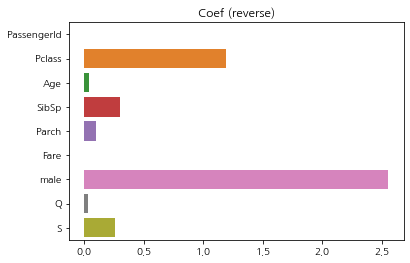

In [23]:
_ = sns.barplot(x=-(model_log.coef_[-1]), y=features_names).set_title("Coef (reverse)")

그래프를 좀 더 편하게 보기 위해, `-`를 붙여 그림  
로지스틱 회귀 모델에서는 `PassengerID`가 영향이 거의 없다는 것을 확인 가능함

### Decision Tree
트리 기반의 `CART` 알고리즘을 이용한 분류

In [24]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
y_predict = model_dt.predict(X_test)

In [26]:
accuracy_score(y_test, y_predict)

0.7

#### 모델 분석 (Decision Tree)

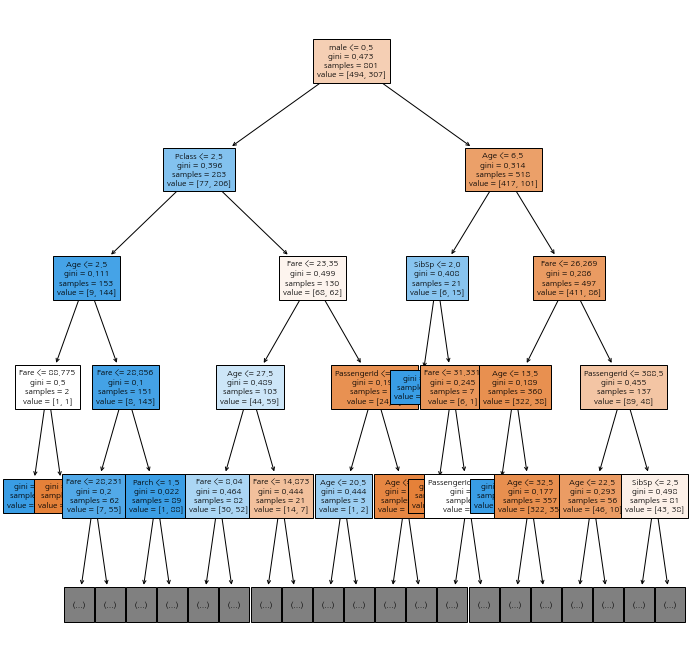

In [27]:
plt.figure(figsize=(12, 12))
pt = plot_tree(model_dt, filled=True, fontsize=8, feature_names=features_names, max_depth=4)
plt.show()

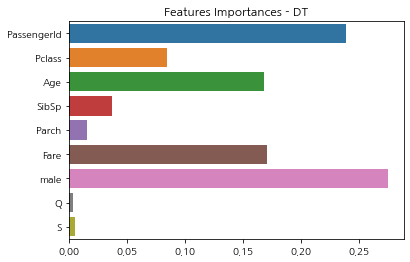

In [33]:
_ = sns.barplot(x=model_dt.feature_importances_, y=features_names).set_title("Features Importances - DT")

로지스틱 회귀와 동일하게 `Sex(male)`이 가장 중요한 특성인것을 확인 가능하지만, `PassengerID`가 중요도가 높게 나온것은 의외임

### Random Forest
Decision Tree가 Overfitting 될 가능성을 염두하고, 일반화된 트리를 만드는 방법이 **Random Forest** 방법임  
기본적으로 앙상블 모델이며, Decsion Tree에서 최대 트리 높이(`max_depth`)를 조절해 Overfitting을 방지하는 것이 아니라,  
여러개의 Decision Tree를 이용해 가장 높은 점수를 얻은 결정 트리를 이용하는 방식  

In [29]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [30]:
y_predict = rf.predict(X_test)

In [31]:
accuracy_score(y_test, y_predict)

0.8555555555555555

#### 모델 분석 (Random Forest)

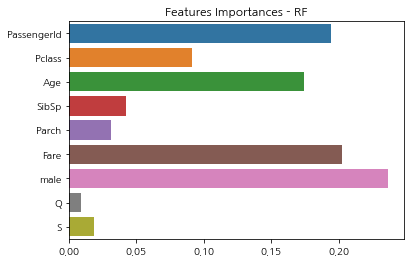

In [34]:
_ = sns.barplot(x=rf.feature_importances_, y=features_names).set_title("Features Importances - RF")

Decision Tree를 이용한 방식과 동일하게 `Sex`다음으로 `PassengerID`의 영향이 큽니다

## 종합
데이터 전처리 이외의 튜닝 없이 로지스틱 회귀의 성능이 가장 좋았습니다.  
하지만, `PassengerID`의 경우 단순히 인덱스의 역할을 하므로, 제거한 상태에서 다시 학습을 시켜보며 하이퍼파라미터 튜닝도 진행해보겠습니다.
### PassengerId 삭제

In [37]:
target = "Survived"
features_names = train.columns.tolist()
features_names.remove(target)
features_names.remove("PassengerId")
X_train, X_test, y_train, y_test = train_test_split(train[features_names], train[target], test_size=0.1, stratify=train[target])
print(f"X_trian: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_trian: (801, 8)
y_train: (801,)
X_test: (90, 8)
y_test: (90,)


### 그리디 서치를 이용한 하이퍼파라미터 튜닝
로지스틱 회귀 모델과 랜덤 포레스트 모델의 `max_iter`는 1000으로 고정해 사용  
로지스틱 회귀 모델에서는 하이퍼파라미터 튜닝을 딱히 진행하지 않음  
`random_state`는 42로 고정

In [42]:
parameters = {"max_depth": np.unique(np.random.randint(1, 20, 10)), "max_features": np.unique(np.random.uniform(0, 1, 10))}

#### Logistic Regression

In [45]:
clf_log = LogisticRegression(max_iter=1000, random_state=42)
clf_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [46]:
y_predict_log = clf_log.predict(X_test)
accuracy_score(y_test, y_predict_log)

0.7666666666666667

`PassengerId`를 제거하니 성능이 급격히 떨어졌습니다
#### Decision Tree

In [49]:
model = DecisionTreeClassifier(random_state=42)

In [50]:
clf_dt = GridSearchCV(estimator=model, param_grid=parameters, scoring="accuracy", n_jobs=-1, cv=3)
clf_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  3,  4,  8, 10, 13, 16, 19]),
                         'max_features': array([0.07495079, 0.32000297, 0.32198288, 0.33313868, 0.41905471,
       0.57081778, 0.62043259, 0.74574933, 0.76830582, 0.96852185])},
             scoring='accuracy')

In [51]:
clf_dt.best_score_

0.8164794007490638

In [55]:
clf_dt.best_estimator_

DecisionTreeClassifier(max_depth=4, max_features=0.7683058212159564,
                       random_state=42)

#### Random Forest

In [52]:
model = RandomForestClassifier(n_estimators=1000, random_state=42)

In [53]:
clf_rf = GridSearchCV(estimator=model, param_grid=parameters, scoring="accuracy", n_jobs=-1, cv=3)
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=1000,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  3,  4,  8, 10, 13, 16, 19]),
                         'max_features': array([0.07495079, 0.32000297, 0.32198288, 0.33313868, 0.41905471,
       0.57081778, 0.62043259, 0.74574933, 0.76830582, 0.96852185])},
             scoring='accuracy')

In [54]:
clf_rf.best_score_

0.8264669163545569

In [56]:
clf_rf.best_estimator_

RandomForestClassifier(max_depth=8, max_features=0.32000296990700017,
                       n_estimators=1000, random_state=42)

## 종합
기본적으로 데이터 전처리를 통해 모델의 성능을 높일 수 있었지만, `PassengerId`는 단순히 인덱스 역할이라 생각해 제거하고 학습을 진행한 결과  
로지스틱 회귀 모형에서는 성능이 감소했지만, Tree 기반 알고리즘에서는 성능이 대폭 향상된 모습을 볼 수 있었음